<a href="https://colab.research.google.com/github/rrl7012005/Audio-Recognition-and-Generation/blob/main/Speech_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolutional Neural Networks for Speech Recognition

We will build a speech recognition model to classify and recognize 8 different words, (down, go, left, no, right, stop, up, yes). The inputs are in WAV format.

To obtain the tf dataset use tf.keras.utils.audio_dataset_from_directory, analogous to image_dataset_from_directory

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, models
from IPython import display

seed = 42
tf.random.set_seed(42)
np.random.seed(seed)

The dataset we use will be a smaller version of 105,000 audio files in WAV format of people saying 35 different words (around one second clips).

In [ ]:
data_dir = pathlib.Path('data/mini_speech_commands')

if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data'
  )

182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Lets obtain the labels (the commands)

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['yes' 'right' 'go' 'left' 'stop' 'down' 'up' 'no']


Now since data is divided into directories we can easily load the data. The audio clips are 1 second or less sampled at 16kHz (default) but we pad them to exactly one second and trim the longer ones. The sequence length is the number of samples.

##Data Processing

In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both' #both subsets
)

label_names = np.array(train_ds.class_names)
print()
print('Label names:', label_names)

train_ds.element_spec

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

Label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

The dataset only contains single channel audio, so use tf.squeeze to drop the extra axis.

In [ ]:
def squeeze(audio, label):
    audio = tf.squeeze(audio, axis=-1)
    return audio, label

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

Split the validation datasets into a val set and a test set

In [ ]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape, example_labels.shape)

(32, 16000) (32,)


Lets plot a few audio waveforms

In [ ]:
label_names[[0, 1, 2, 3, 4, 5, 6, 7]]

array(['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes'],
      dtype='<U5')

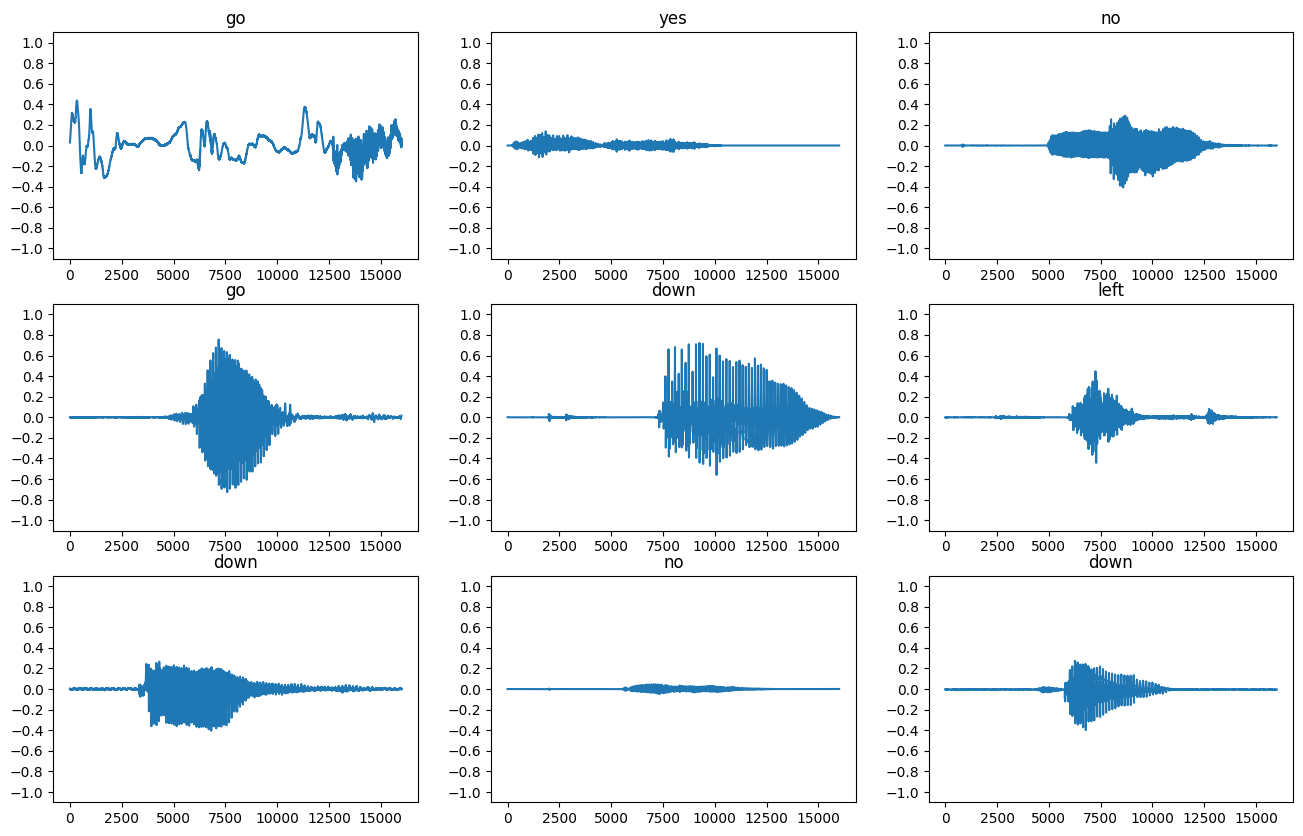

In [ ]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols

for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

Plotting the decimal magnitude against time. This plot is a waveform.

The waveforms here are represented in the time domain. We can convert these signals into time frequency domain signals by computing the short time fourier transform (STFT) to convert the waveforms to spectrograms, which show frequency changes over time and can be represented as 2D images, so can use CNNs.

tf.signal.fft converts a signal to its frequencies but loses time information, stft keeps that.

The waveforms need to be of same length so spectrograms have same dimensions which is why we zero padded. We choose the frame_length and frame_step parameters such that the spectrogram image is almost square.

STFT produces an array of complex numbers representing magnitude and phase. Here we will only use the magnitude.

In [ ]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Lets insppect the spectrograms

In [ ]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000)) #get the audio noise

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


plot the spectrogram
 We convert fequencies to log scale and transpose so time is on the x axis, add an epsilon to avoid log zero.

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)

  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]

  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)

  ax.pcolormesh(X, Y, log_spec)

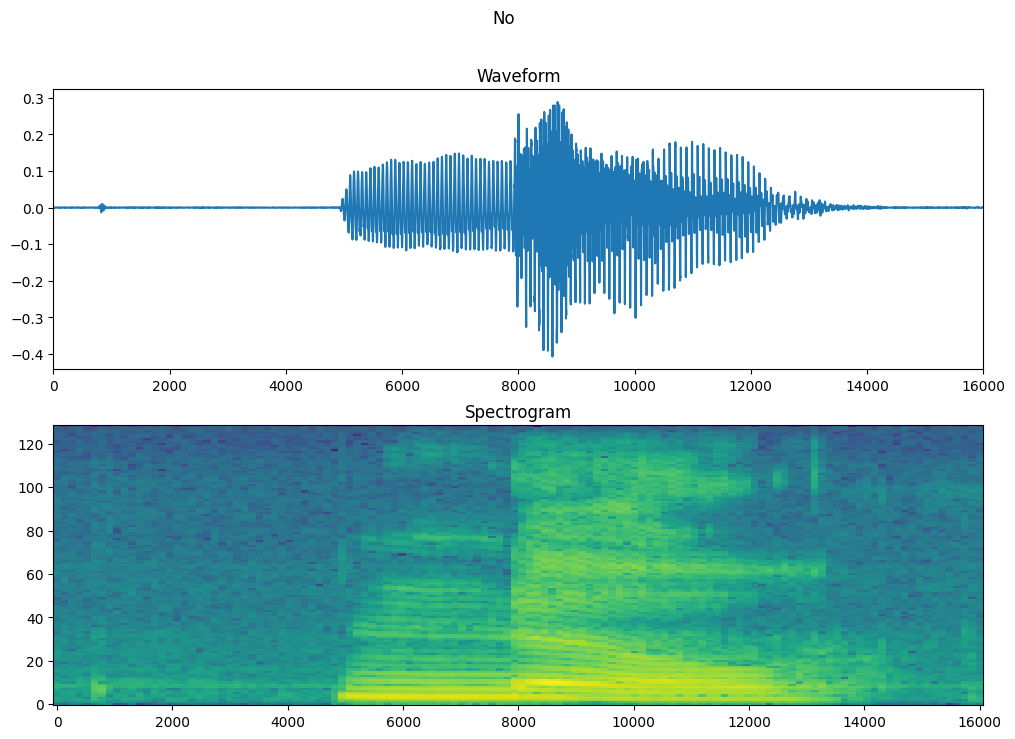

In [ ]:
fig, axs = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axs[0].plot(timescale, waveform.numpy())
axs[0].set_title('Waveform')
axs[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axs[1])
axs[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

So lets map that to our dataset

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio, label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

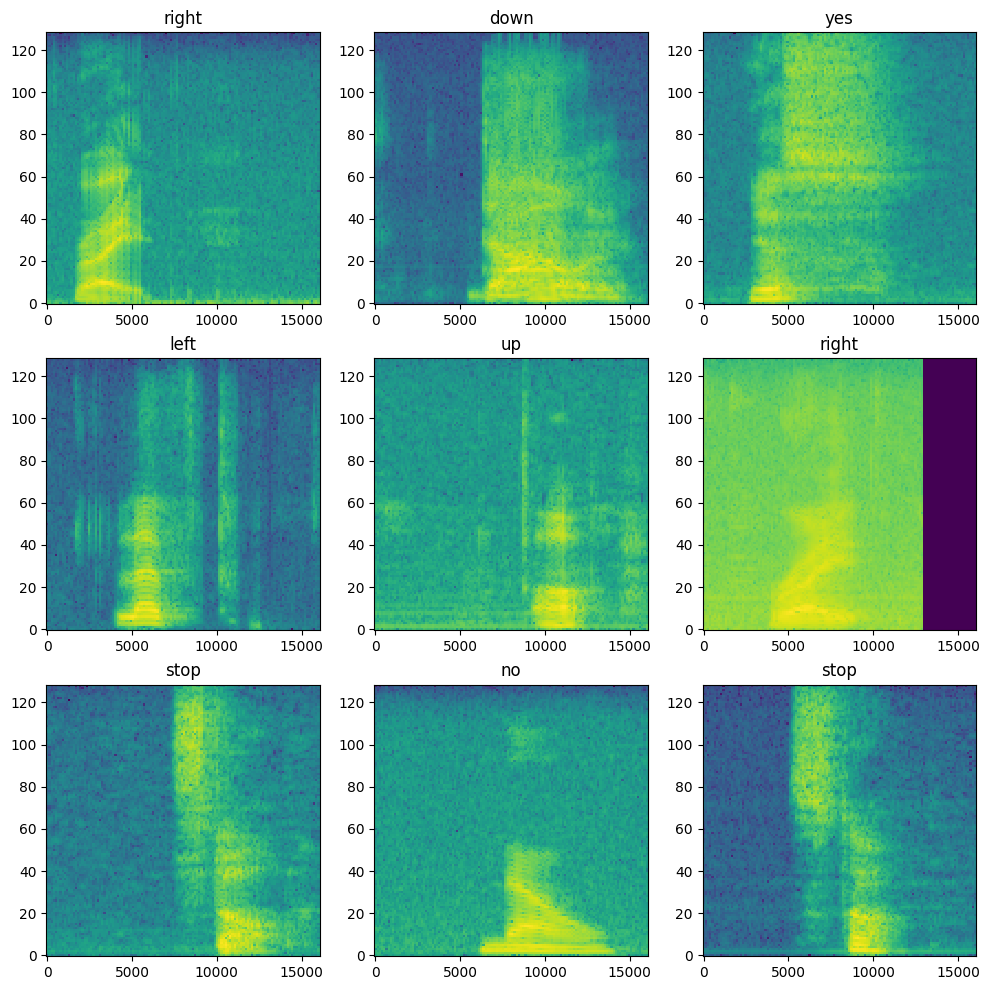

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

rows, cols = 3, 3
n = rows*cols
fig, axs = plt.subplots(rows, cols, figsize=(12, 12))

for i in range(n):
  r = i // cols
  c = i % cols
  ax = axs[r][c]
  plot_spectrogram(example_spectrograms[i].numpy(), ax)
  ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

Lets create our final dataset

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

##Model

We will resize the input and downsample so the model trains faster. Normalize each pixel based on its mean and sd

In [ ]:
input_shape = example_spectrograms.shape[1:]
print(input_shape)

num_labels = len(label_names)

norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

(124, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

Conv Conv Pool, 1 hidden dense layer

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

epochs = 10

history = model.fit(train_spectrogram_ds, validation_data=val_spectrogram_ds,
                    epochs=epochs, callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 130ms/step - accuracy: 0.2842 - loss: 1.9146 - val_accuracy: 0.5987 - val_loss: 1.2407
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 148ms/step - accuracy: 0.5879 - loss: 1.1842 - val_accuracy: 0.7300 - val_loss: 0.8611
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - accuracy: 0.6958 - loss: 0.8635 - val_accuracy: 0.7850 - val_loss: 0.6993
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 149ms/step - accuracy: 0.7478 - loss: 0.7062 - val_accuracy: 0.7675 - val_loss: 0.6326
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 183ms/step - accuracy: 0.7850 - loss: 0.5925 - val_accuracy: 0.8062 - val_loss: 0.5488
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 32s 161ms/step - accuracy: 0.8228 - loss: 0.4787 - val_accuracy: 0.8250 - val_loss: 0.5127
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.8550 - loss: 0.4206 - val_accuracy: 0.8138 - val_loss: 0.4973
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 127ms/step - accuracy: 0.8700 - loss: 0

Plot the loss

In [ ]:
len(train_spectrogram_ds)

200

Text(0, 0.5, 'Accuracy [%]')

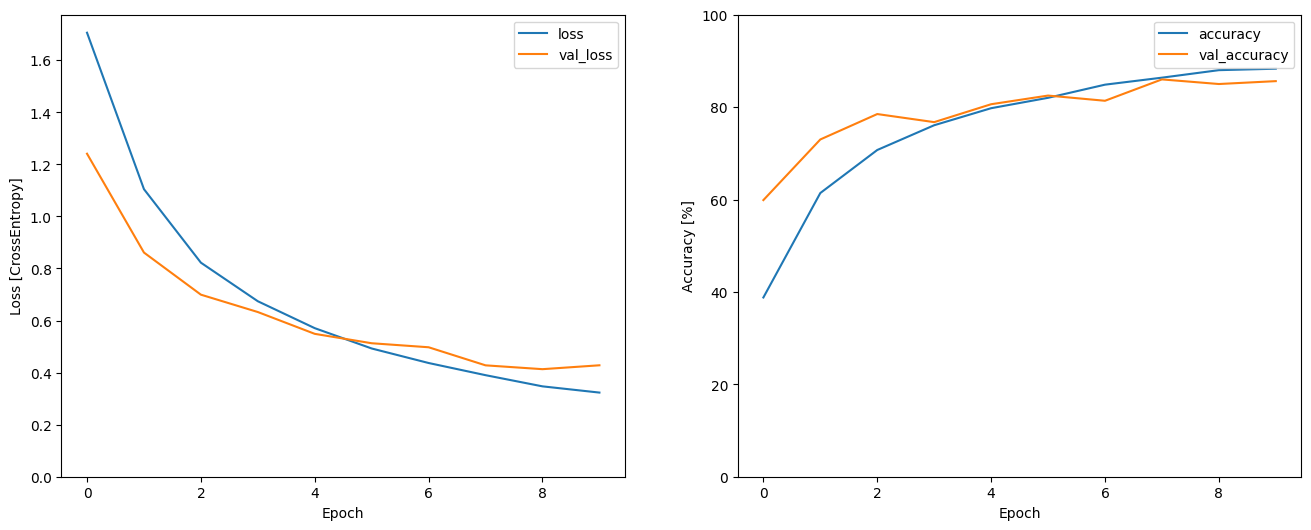

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

##Prediction

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.8523 - loss: 0.4557


{'accuracy': 0.8424999713897705, 'loss': 0.4780985713005066}

Display a confusion matrix

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


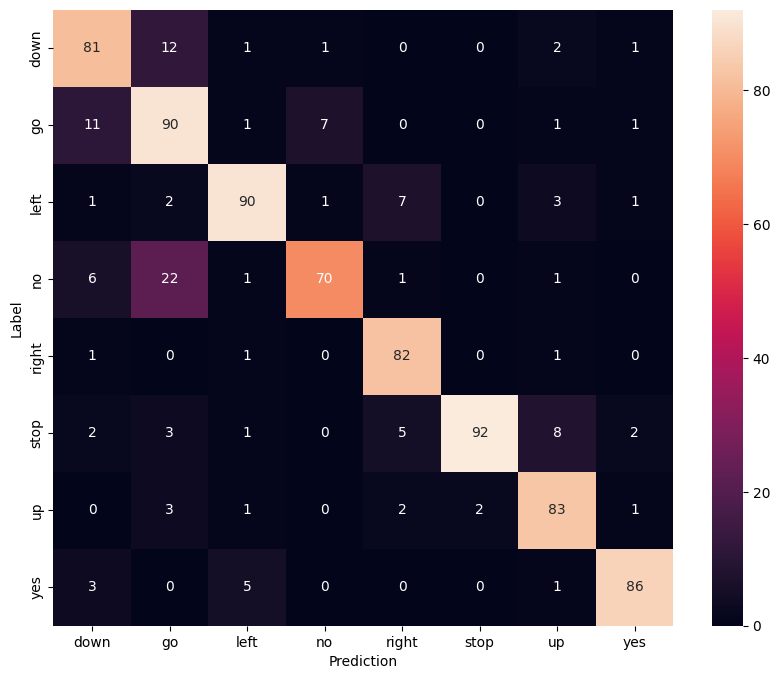

In [ ]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

conf_mat = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Run inference on an audio file

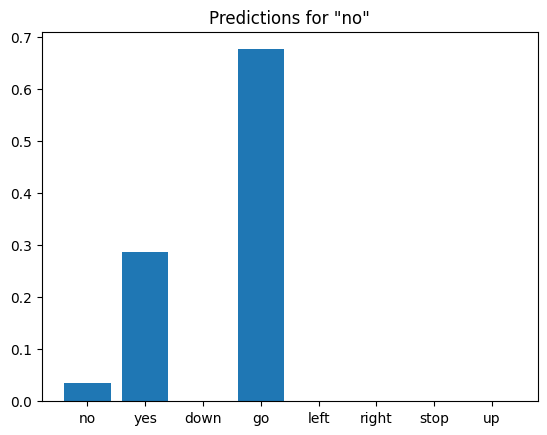

In [ ]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000)
x = tf.squeeze(x, axis=-1)

waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis, ...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'right', 'stop', 'up']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title(f'Predictions for "{label}"')
plt.show()

display.display(display.Audio(waveform, rate=16000))

##Saving

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))

  @tf.function

  def __call__(self, x):
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions': result, 'class_ids': class_ids, 'class_names': class_names}

In [ ]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 0.77737147,  2.8838353 , -2.925178  ,  3.7389705 , -5.5692263 ,
         -3.7980034 , -4.93162   , -3.733948  ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

In [ ]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 0.77737147,  2.8838353 , -2.925178  ,  3.7389705 , -5.5692263 ,
         -3.7980034 , -4.93162   , -3.733948  ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

#Transfer Learning YAMNet

YAMNet is a pretrained network that uses MobileNet architecture (depthwise separable convolution architecture). It can use an audio waveform as input and is trained to predict one of 521 audio events from the AudioSet corpus.

The model extracts frames from the audio signal and processes batches of these frames. This version of the model uses frames which are 0.96 seconds long and extracts a frame every 0.48 seconds. the model accepts a 1D float32 tensor or np array containing a waveform of arbitraty length represented as single channel 16 khz samples in the range [-1, 1]. The model outputs 3 things, the class scores, embeddings and the log mel spectrogram.

YAMNet is used as a high level feature extractor.


In [ ]:
!pip install tensorflow_io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 8.9 MB/s eta 0:00:00


In [ ]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

In [ ]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

Can download a single wav file for inference

In [ ]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

215546/215546 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
./test_data/miaow_16k.wav


Lets create a function to load audio files

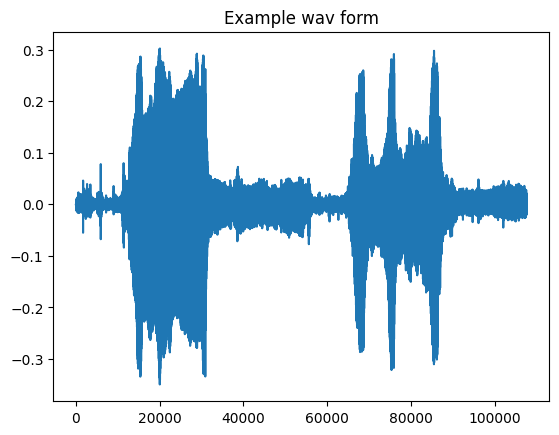

In [ ]:
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

testing_wav_data = load_wav_16k_mono(testing_wav_file_name)
testing_wav_data_np = testing_wav_data.numpy()

plt.plot(testing_wav_data_np)
plt.title('Example wav form')
plt.show()

display.Audio(testing_wav_data_np, rate=16000)


load the class mappings

In [ ]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names = list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing


YAMNet provides frame level class scores so 521 scores for every frame. In order to determine clip level predictions, the scores are aggregated per class across frames (using mean or max pooling).

In [ ]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The class score is: {class_scores[top_class].numpy()}')
print(f'The embeddings shape is: {embeddings.shape}')

The main sound is: Animal
The class score is: 0.709294319152832
The embeddings shape is: (13, 1024)


The model generated 13 embeddings, 1 per frame.

Consider the ESC-50 dataset, a labelled collection of 2000 5 second long environmental audio recordings. There are 50 classes, 40 examples per class

In [ ]:
tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

645701632/Unknown 43s 0us/step

'./datasets/esc-50.zip'

The metadata for each file is in the csv file.

./datasets/ESC-50-master/meta/esc50.csv

and the audio files are in ./datasets/ESC-50-master/audio/

In [ ]:
esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


We will simplify our dataset and only choose 2 classes (dog and cat)

In [ ]:
my_classes = ['dog', 'cat']
map_class_to_id = {'dog':0, 'cat': 1}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category,esc10,src_file,take
0,./datasets/ESC-50-master/audio/1-100032-A-0.wav,1,0,dog,True,100032,A
14,./datasets/ESC-50-master/audio/1-110389-A-0.wav,1,0,dog,True,110389,A
157,./datasets/ESC-50-master/audio/1-30226-A-0.wav,1,0,dog,True,30226,A
158,./datasets/ESC-50-master/audio/1-30344-A-0.wav,1,0,dog,True,30344,A
170,./datasets/ESC-50-master/audio/1-32318-A-0.wav,1,0,dog,True,32318,A
175,./datasets/ESC-50-master/audio/1-34094-A-5.wav,1,1,cat,False,34094,A
176,./datasets/ESC-50-master/audio/1-34094-B-5.wav,1,1,cat,False,34094,B
229,./datasets/ESC-50-master/audio/1-47819-A-5.wav,1,1,cat,False,47819,A
230,./datasets/ESC-50-master/audio/1-47819-B-5.wav,1,1,cat,False,47819,B
231,./datasets/ESC-50-master/audio/1-47819-C-5.wav,1,1,cat,False,47819,C


Here will load and prepare the WAV data for the model.

The model will use each frame as one input, so we need to create a new column that has one frame per row. Expand the labels and the fold columnt to properly reflect these new rows. The expanded fold column keeps the original values, we cannot mix frames because we'd end up having different parts of the same audio on different splits.

In [ ]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
def extract_embedding(wav_data, label, fold):
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]

  return (embeddings, tf.repeat(label, num_embeddings), tf.repeat(fold, num_embeddings))

main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

ESC-50 is arranged into 5 uniform cross validation folds, we are not going to use the fold column in training so remove that

In [ ]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

Now we can define the model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,826 (2.01 MB)

 Trainable params: 525,826 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

history = model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8966 - loss: 0.4071 - val_accuracy: 0.8625 - val_loss: 0.7311
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9357 - loss: 0.2871 - val_accuracy: 0.9000 - val_loss: 0.2503
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9117 - loss: 0.1785 - val_accuracy: 0.8750 - val_loss: 0.2979
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9370 - loss: 0.1326 - val_accuracy: 0.9000 - val_loss: 0.2621
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9535 - loss: 0.1008 - val_accuracy: 0.9125 - val_loss: 0.2094
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9338 - loss: 0.1143 - val_accuracy: 0.8750 - val_loss: 0.2803
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9347 - loss: 0.1274 - val_accuracy: 0.8750 - val_loss: 0.3995
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9327 - loss: 0.2081 - val_accuracy: 0.8625 - val_loss: 0.9060


Evaluate the test data

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8913 - loss: 0.2094
Loss:  0.29918351769447327
Accuracy:  0.824999988079071


In [ ]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]

print(f'The main sound is: {inferred_class}')
print(f'The class score is: {result.mean(axis=0).max()}')

The main sound is: cat
The class score is: 4.751258850097656


Modify the preprocessing so models can directly take in a WAV file as an input

In [ ]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [ ]:
saved_model_path = 'dogs_and_cats_yamnet.keras'

class YamNetEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, yamnet_model_url, **kwargs):
        super(YamNetEmbeddingLayer, self).__init__(**kwargs)
        self.yamnet_model = hub.KerasLayer(yamnet_model_url, trainable=False)

    def call(self, inputs):
        _, embeddings, _ = self.yamnet_model(inputs)
        return embeddings


embedding_extraction_layer = YamNetEmbeddingLayer(yamnet_model_handle)
input_segment = tf.keras.Input(shape=(), dtype=tf.float32, name='audio')

embeddings_output = embedding_extraction_layer(input_segment)

serving_outputs = model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

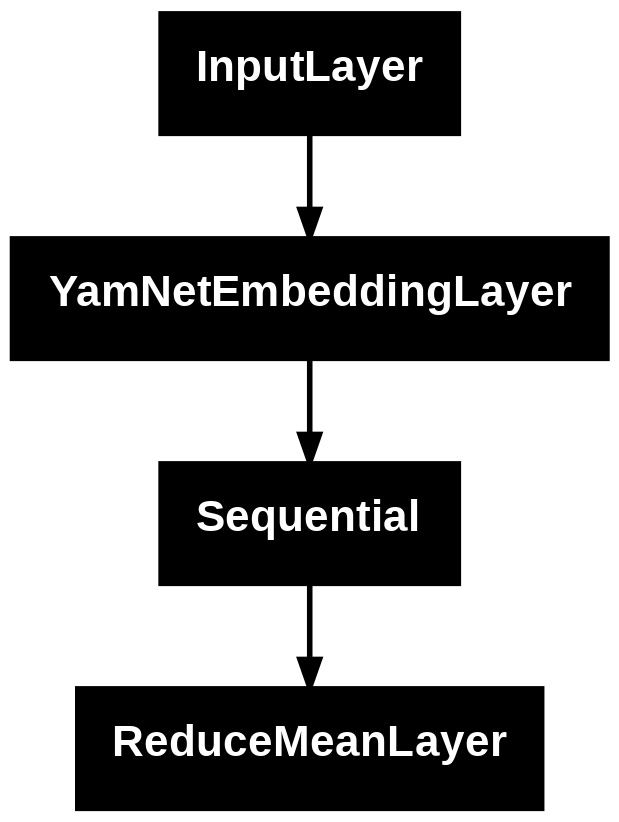

In [ ]:
tf.keras.utils.plot_model(serving_model)

Load  the model

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

reloaded_results = reloaded_model(testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(reloaded_results)]
print(f'The main sound is: {cat_or_dog}')

OSError: SavedModel file does not exist at: dogs_and_cats_yamnet.keras/{saved_model.pbtxt|saved_model.pb}

Use the serving default signature to try the model on a serving setup.

In [ ]:
serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(serving_results['classifier'])]
print(f'The main sound is: {cat_or_dog}')

Some more testing

In [ ]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 5]
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [ ]:
scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]
top_score = class_scores[top_class]
print(f'[YAMNet] The main sound is: {inferred_class} ({top_score})')

reloaded_results = reloaded_model(waveform)
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')